<a href="https://colab.research.google.com/github/Hydra-Bolt/ImageCaptioining/blob/main/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import json
import time
import random
from textwrap import wrap
import matplotlib.pylab as plt
import numpy as np
import imageio as io
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import re
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)

2.13.0


In [ ]:
if not os.path.exists('/content/data/'):

    api_token = {"username": "mneebahmd",
                 "key": "8780864e64c60e98d53a39dd2e09a02a"}

    with open('/content/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

    os.system('kaggle datasets download -d adityajn105/flickr8k')
    os.makedirs('/content/data/', exist_ok=True)
    os.system('mv /content/flickr8k.zip /content/data/flickr8k.zip')
    os.system('unzip -q /content/data/flickr8k.zip -d /content/data/')
    os.remove('/content/data/flickr8k.zip')

In [ ]:
ATTENTION_DIM = 512
WORD_EMBED_DIM = 128
VOCAB_SIZE = 20000


FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 [==============================] - 1s 0us/step


Lets see our data

In [ ]:
captions = pd.read_csv("/content/data/captions.txt")

In [ ]:
def preprocess(text):
  #cleaning the dataset
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    return text

In [ ]:
captions ["image"] = captions["image"].apply(
    lambda img: "/content/data/Images/"+ img
)
captions

captions.caption = captions.caption.apply(preprocess)

In [ ]:
captions

,image,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,/content/data/Images/1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,/content/data/Images/1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,/content/data/Images/1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,/content/data/Images/1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
...,...,...
40450,/content/data/Images/997722733_0cb5439472.jpg,a man in a pink shirt climbs a rock face
40451,/content/data/Images/997722733_0cb5439472.jpg,a man is rock climbing high in the air
40452,/content/data/Images/997722733_0cb5439472.jpg,a person in a red shirt climbing up a rock fac...
40453,/content/data/Images/997722733_0cb5439472.jpg,a rock climber in a red shirt


<ipython-input-9-296f6a86039d>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax[i, j].imshow(io.imread(captions["image"][indice]))


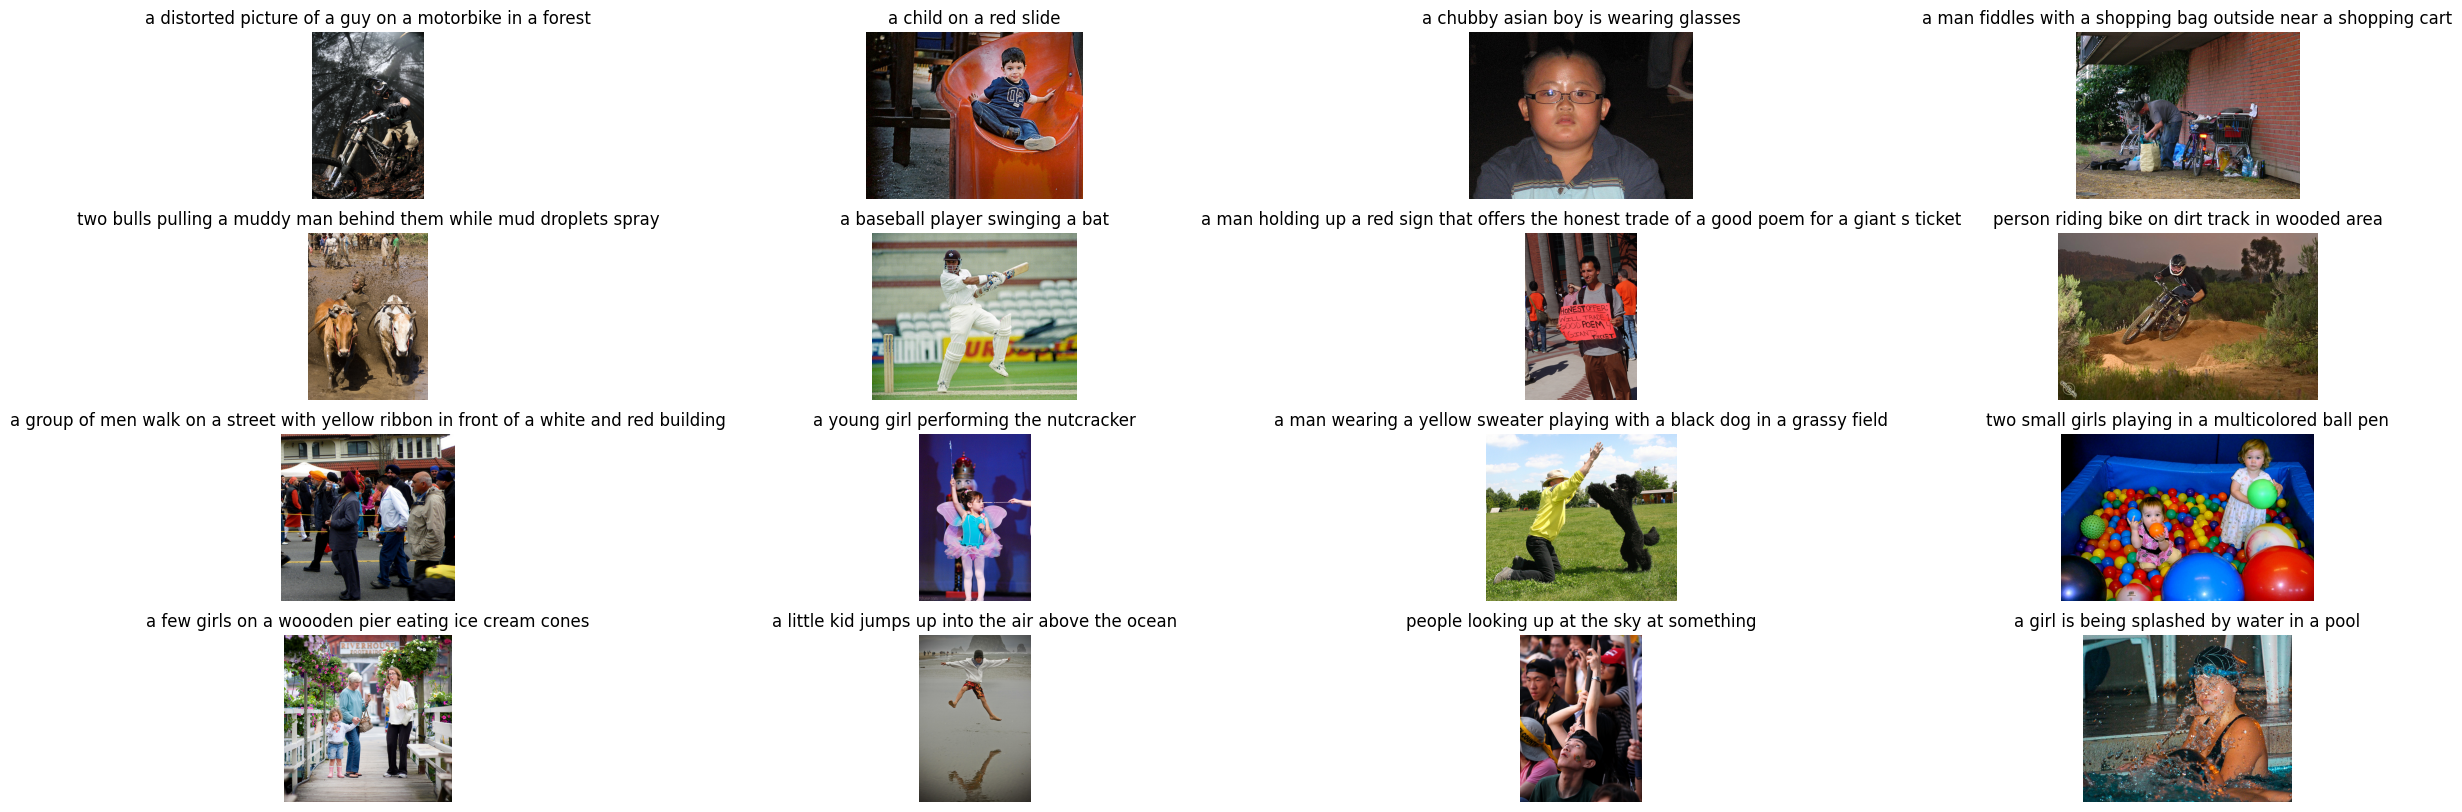

In [ ]:
fig, ax = plt.subplots(4,4, figsize= (30,10))
for i in range(4):
  for j in range(4):
    indice =random.randint(1,40444)
    ax[i, j].imshow(io.imread(captions["image"][indice]))
    ax[i, j].set_title(captions["caption"][indice])
    ax[i, j].axis("off")
plt.show()

In [ ]:
captions["caption"]

0        a child in a pink dress is climbing up a set o...
1                      a girl going into a wooden building
2           a little girl climbing into a wooden playhouse
3        a little girl climbing the stairs to her playh...
4        a little girl in a pink dress going into a woo...
                               ...                        
40450             a man in a pink shirt climbs a rock face
40451               a man is rock climbing high in the air
40452    a person in a red shirt climbing up a rock fac...
40453                        a rock climber in a red shirt
40454     a rock climber practices on a rock climbing wall
Name: caption, Length: 40455, dtype: object

In [ ]:
def add_start_end_token(data):
  start  = tf.convert_to_tensor("<start>")
  end  = tf.convert_to_tensor(" <end>")
  data['caption'] = tf.strings.join(
      [start, data['caption'] + end], separator = " "
  )
  return data
captions = add_start_end_token(captions)
captions

,image,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,b'<start> a child in a pink dress is climbing ...
1,/content/data/Images/1000268201_693b08cb0e.jpg,b'<start> a girl going into a wooden building ...
2,/content/data/Images/1000268201_693b08cb0e.jpg,b'<start> a little girl climbing into a wooden...
3,/content/data/Images/1000268201_693b08cb0e.jpg,b'<start> a little girl climbing the stairs to...
4,/content/data/Images/1000268201_693b08cb0e.jpg,b'<start> a little girl in a pink dress going ...
...,...,...
40450,/content/data/Images/997722733_0cb5439472.jpg,b'<start> a man in a pink shirt climbs a rock ...
40451,/content/data/Images/997722733_0cb5439472.jpg,b'<start> a man is rock climbing high in the a...
40452,/content/data/Images/997722733_0cb5439472.jpg,b'<start> a person in a red shirt climbing up ...
40453,/content/data/Images/997722733_0cb5439472.jpg,b'<start> a rock climber in a red shirt <end>'


In [ ]:
img_to_captions = {}
for img, cap in zip(captions['image'], captions['caption']):
    if img not in img_to_captions:
      img_to_captions[img] = []
    img_to_captions[img].append(cap)
img_to_captions
img_keys = list(img_to_captions.keys())
img_keys
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_captions[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_captions[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_captions[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_captions[imgv])

In [ ]:
MAX_CAPTION_LEN = 64

def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )
tokenizer = TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize = standardize,
    output_sequence_length = MAX_CAPTION_LEN
)
tokenizer.adapt(train_captions)




In [ ]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(IMG_WIDTH, IMG_HEIGHT)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

In [ ]:
tokenizer("<start> testing phrase <end>")

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([   3,    1, 3273,    4,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])>

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    )

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    )

In [ ]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'<start>', b'a', b'woman', b'walks', b'as', b'she', b'looks',
       b'at', b'her', b'cellphone', b'and', b'others', b'look', b'on',
       b'<end>', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b''],
      dtype=object)>

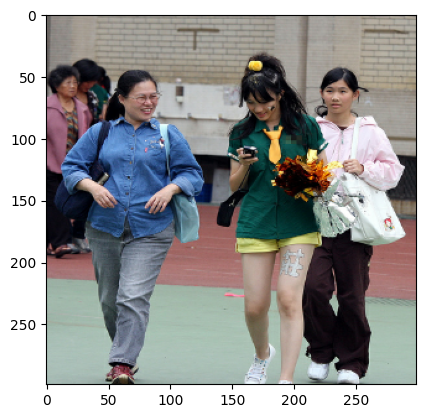

In [ ]:
BATCH_SIZE = 32

def create_ds_fn(img_tensor, capt):

  target = tf.roll(capt, -1, 0)
  zeros = tf.zeros([1], dtype = tf.int64)
  target = tf.concat((target[:-1], zeros), axis = -1)
  return (img_tensor, capt), target

train_batched = (
    train_dataset.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder = True)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

# Assuming train_batched is your batched dataset
batch = next(iter(train_batched))
ption = batch[0][1][0]  # Get the first image from the batch
images = batch[0][0][0]  # Get the first image from the batch
plt.imshow(images)
idx2word(ption)

In [ ]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

In [ ]:
encoder = tf.keras.Model(inputs = image_input, outputs = encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55123680 (210.28 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [ ]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = Attention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

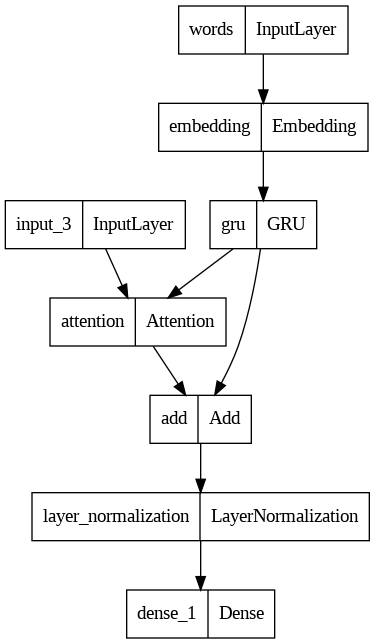

In [ ]:
decoder = tf.keras.Model(
    inputs = [word_input, encoder_output], outputs = decoder_output
)
tf.keras.utils.plot_model(decoder)

In [ ]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 512)              1024000   ['words[0][0]']               
                                                          0                                       
                                                                                                  
 gru (GRU)                   [(None, 64, 512),            1575936   ['embedding[1][0]']           
                              (None, 512)]                                                        
                                                                                            

In [ ]:
image_caption_train_model = tf.keras.Model(
    inputs = [image_input, word_input], outputs = decoder_output
)

In [ ]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True,
    reduction = "none"
)
def loss_func(real, pred):
  loss_  = loss_obj(real, pred)

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  mask = tf.cast(mask, dtype = tf.int32)
  sentence_len = tf.reduce_sum(mask)
  loss_ = loss_[:sentence_len]
  return tf.reduce_mean(loss_, 1)


In [ ]:
image_caption_train_model.compile(
    optimizer = 'adam',
    loss = loss_func
)


In [ ]:

history = image_caption_train_model.fit(train_batched, epochs=5)

Epoch 1/2
1011/1011 [==============================] - 391s 363ms/step - loss: 0.7981
Epoch 2/2
1011/1011 [==============================] - 352s 349ms/step - loss: 0.5363


In [ ]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_attention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)

In [ ]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word2idx("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word2idx("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

In [ ]:
word2idx("<end>")

<tf.Tensor: shape=(), dtype=int64, numpy=4>

a man in an suit sitting in a chair.
the man in a pink shirt holds a paper.
a bald eagle sits on an outdoor counter.
an elderly woman with a pink shirt sitting on a table.
a man sits on a cellphone while a man holds her head while others watch.


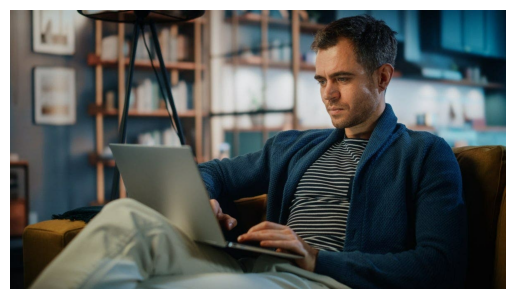

In [ ]:
from PIL import Image
import requests
url = "/content/media_12b27eb701c9843393ecfa9277ba172d6bbf08cfe.jpg"
# img = Image.open(requests.get(url, stream=True).raw)
# img.save('tmp.jpg')

for i in range(5):
    image, caption = predict_caption(url)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(url), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

(array([[[0.9178802 , 0.9198082 , 0.86440784],
        [0.8920871 , 0.9281681 , 0.8842964 ],
        [0.50737756, 0.55631196, 0.5317202 ],
        ...,
        [0.45479053, 0.41843393, 0.3699456 ],
        [0.44905666, 0.41931516, 0.36751923],
        [0.44705883, 0.41602138, 0.36487344]],

       [[0.9152618 , 0.9156946 , 0.86079264],
        [0.8976398 , 0.92644167, 0.88649154],
        [0.51132   , 0.56023353, 0.537113  ],
        ...,
        [0.4588324 , 0.42748377, 0.3764914 ],
        [0.45155233, 0.42505744, 0.3716382 ],
        [0.44706297, 0.42353356, 0.36868888]],

       [[0.92235917, 0.91580254, 0.8632304 ],
        [0.9033487 , 0.93215054, 0.8922004 ],
        [0.51039916, 0.5568415 , 0.53866327],
        ...,
        [0.46085897, 0.43234548, 0.37993556],
        [0.45514467, 0.43161526, 0.3767133 ],
        [0.4502263 , 0.4266969 , 0.37398162]],

       ...,

       [[0.37008628, 0.355218  , 0.35181394],
        [0.27434897, 0.2442794 , 0.19850294],
        [0.26062536, 

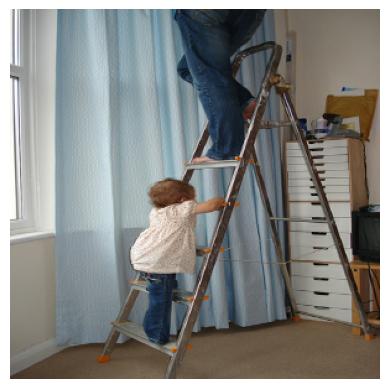

In [ ]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = next(val_dataset.as_numpy_iterator())[0]
    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word2idx("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word2idx("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result
image, caption = predict_caption(url)
print(" ".join(caption[:-1]) + ".")
plt.imshow(image)
plt.axis("off");